# Imports

In [1]:
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mattkarenbauer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Read Data

In [2]:
train_df = pd.read_csv('./Data/test.csv')
test_df = pd.read_csv('./Data/train.csv')

# Explore Data

## General Information

In [3]:
print(f"Train Data Shape: {train_df.shape}\n")
print(train_df.info())

Train Data Shape: (3263, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


In [4]:
train_df.dropna().head(3)

,id,keyword,location,text
15,46,ablaze,London,Birmingham Wholesale Market is ablaze BBC News - Fire breaks out at Birmingham's Wholesale Market http://t.co/irWqCEZWEU
16,47,ablaze,Niall's place | SAF 12 SQUAD |,@sunkxssedharry will you wear shorts for race ablaze ?
17,51,ablaze,NIGERIA,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriage crisis sets Nigerian Twitter ablaze... http://t.co/CMghxBa2XI


In [5]:
print(f"Test Data Shape: {test_df.shape}\n")
train_df.info()

Test Data Shape: (7613, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [6]:
test_df.dropna().head(3)

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi,1


## Distribution of Tweets by Target

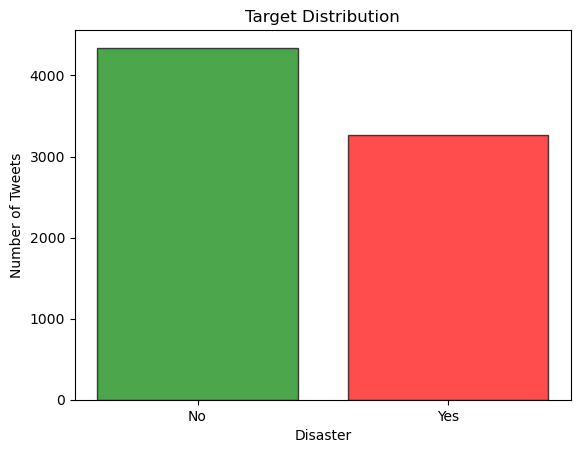

In [7]:
target_counts = test_df['target'].value_counts()

plt.bar(
    ['No', 'Yes'], 
    target_counts.values, 
    color=['green', 'red'],
    alpha=0.7, 
    edgecolor='black'
)

plt.title('Target Distribution')
plt.xlabel('Disaster')
plt.ylabel('Number of Tweets')
plt.show();

## Word Clouds by Target

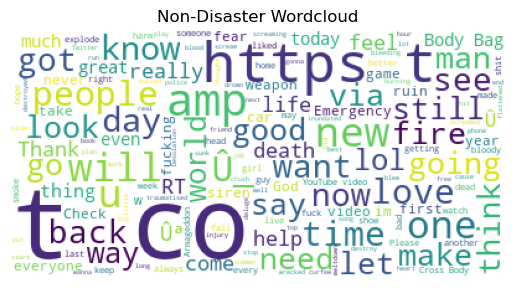

In [8]:
text = ' '.join(
    test_df[test_df['target'] == 0]['text'].dropna().astype(str)
)

plt.axis('off')
plt.title('Non-Disaster Wordcloud')
plt.imshow(WordCloud(background_color='white').generate(text))

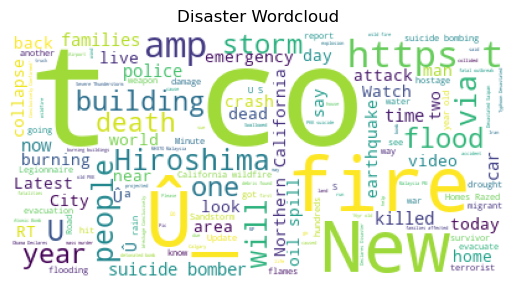

In [9]:
text = ' '.join(
    test_df[test_df['target'] == 1]['text'].dropna().astype(str)
)

plt.axis('off')
plt.title('Disaster Wordcloud')
plt.imshow(WordCloud(background_color='white').generate(text));

# Preprocess Data

## Clean Text

In [10]:
# flag if the text has a link; it could be indicative of a real disaster

train_df['has_link'] = train_df['text'].apply(
    lambda text: 1 if re.search(r'https?://[^\s]+', text) else 0
)

test_df['has_link'] = test_df['text'].apply(
    lambda text: 1 if re.search(r'https?://[^\s]+', text) else 0
)

In [11]:
# remove links from text
train_df['text'] = train_df['text'].str.replace(
    r'http[s]?://\S+|www\.\S+', '', regex=True
)
test_df['text'] = test_df['text'].str.replace(
    r'http[s]?://\S+|www\.\S+', '', regex=True
)

In [12]:
# remove puncuation to start cleaning text

translator = str.maketrans('', '', string.punctuation)

STOPWORDS = [word.translate(translator) for word in stopwords.words('english')]

train_df['text'] = train_df['text'].apply(lambda w: w.translate(translator))
test_df['text'] = test_df['text'].apply(lambda w: w.translate(translator))

In [13]:
test_df.dropna().head(5)

,id,keyword,location,text,target,has_link
31,48,ablaze,Birmingham,bbcmtd Wholesale Markets ablaze,1,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy metal RT,0,1
33,50,ablaze,AFRICA,AFRICANBAZE Breaking newsNigeria flag set ablaze in Aba,1,1
34,52,ablaze,"Philadelphia, PA",Crying out for more Set me ablaze,0,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE,0,1


## Distribution of Tweets with Links by Target

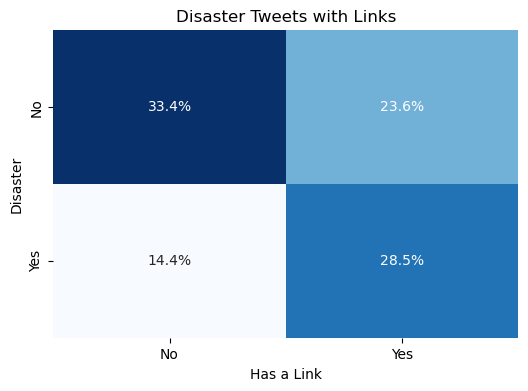

In [14]:
confusion_matrix = pd.crosstab(
    test_df['target'], 
    test_df['has_link'], 
    rownames=['target'],
    colnames=['has_link']
)

annotations = confusion_matrix.apply(
    lambda v: [f'{val/confusion_matrix.sum().sum():.1%}' for val in v], 
    axis=1
)
annotations_df = pd.DataFrame(
    annotations.tolist(), 
    index=confusion_matrix.index, 
    columns=confusion_matrix.columns
)

plt.figure(figsize=(6, 4))
sns.heatmap(
    confusion_matrix, annot=annotations_df, fmt='', cmap='Blues', cbar=False
)
plt.title('Disaster Tweets with Links')
plt.xlabel('Has a Link')
plt.ylabel('Disaster')
plt.xticks(labels=['No', 'Yes'], ticks=[0.5, 1.5])
plt.yticks(labels=['No', 'Yes'], ticks=[0.5, 1.5])
plt.show()